In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import rasterio
import numpy as np
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, random_split
from torchgeo.transforms import indices
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm
from PIL import Image
import dotenv
from datetime import datetime
import wandb
import random

import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning) # biomassters rasters are not georeferenced
warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')

In [3]:
dotenv.load_dotenv()
os.chdir(os.environ['WORKING_DIR'])
import src.utils.transforms as tf
import src.utils.data_loader_v3 as dl
from config import CFG, CFG2
CFG = CFG()

In [4]:
wandb.login()

True

In [5]:
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

if torch.backends.mps.is_available(): # Mac M1/M2
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

loader_device = torch.device('cpu')  # found that using cpu for data loading was faster than gpu (for my device)
print(f'training device: {device}')
print(f'loader_device: {loader_device}')

In [6]:
# Map of tensor channels *after* transforms, not accounting for bands dropped by the DropBands transform
# Useful for choosing which bands to keep 
band_map = CFG2.BAND_MAP
month_map = CFG2.MONTH_MAP

In [7]:
bands_to_keep = CFG.BANDS # via offline feature selection  

transforms = nn.Sequential(
    tf.ClampAGBM(vmin=0., vmax=500.),                # exclude AGBM outliers, 500 is good upper limit per AGBM histograms 
    indices.AppendNDVI(index_nir=6, index_red=2),    # NDVI, index 15
    indices.AppendNormalizedDifferenceIndex(index_a=11, index_b=12), # (VV-VH)/(VV+VH), index 16
    indices.AppendNDBI(index_swir=8, index_nir=6),   # Difference Built-up Index for development detection, index 17
    indices.AppendNDRE(index_nir=6, index_vre1=3),   # Red Edge Vegetation Index for canopy detection, index 18
    indices.AppendNDSI(index_green=1, index_swir=8), # Snow Index, index 19
    indices.AppendNDWI(index_green=1, index_nir=6),  # Difference Water Index for water detection, index 20 
    indices.AppendSWI(index_vre1=3, index_swir2=8),  # Standardized Water-Level Index for water detection, index 21
    tf.AppendRatioAB(index_a=11, index_b=12),        # VV/VH Ascending, index 22
    tf.AppendRatioAB(index_a=13, index_b=14),        # VV/VH Descending, index 23
    tf.DropBands(loader_device, bands_to_keep)       # DROPS ALL BUT SPECIFIED bands_to_keep
)

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    train_metrics = []
    example_ct = 0
    
    print('Training')
    for ix, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch['image'].to(device)
        y = batch['label'].to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_metrics.append(np.round(np.sqrt(loss.item()), 5))

        example_cnt += ix * len(batch)
        if ((ix + 1) % 25) == 0:
            train_log(train_metrics[-1], example_cnt)
            
    return train_metrics


def valid_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    valid_loss = 0
    valid_metrics = {}
    example_ct = 0
    
    print('Validation')
    with torch.no_grad():
        for batch in tqdm(dataloader, total=num_batches):
            X = batch['image'].to(device)
            y = batch['label'].to(device)
            
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()
            
    valid_loss /= num_batches
    valid_rmse = np.round(np.sqrt(valid_loss), 5)
    print(f"Validation Error: \n RMSE: {valid_rmse:>8f} \n")
    wandb.log({"test_accuracy": valid_rmse})
    return valid_rmse

def train_log(loss, example_ct):
    # Where the magic happens
    wandb.log({"loss": loss}, step=example_ct)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

In [9]:
def run_training(model, loss_module, optimizer, train_dataloader, val_dataloader, CFG):
    save_file = f'UNET_resnet50_20band_batch{CFG.BATCH_SIZE}_AGBMLinear_AllTrain_{CFG.EPOCHS}epoch_{datetime.now()}.pt'
    save_path = os.path.join(CFG.SAVED_MODELS, save_file)
    wandb.watch(model, loss_module, log="all", log_freq=10)
    min_valid_metric = np.inf
    train_metrics = []
    valid_metrics = []

    for ix in range(CFG.EPOCHS):
        print(f"\n-------------------------------\nEpoch {ix+1}")
        train_metrics_epoch = train_loop(train_dataloader, model, loss_module, optimizer)
        train_metrics.extend(train_metrics_epoch)
        
        valid_metrics_epoch = valid_loop(val_dataloader, model, loss_module)
        valid_metrics.append((len(train_metrics), valid_metrics_epoch))

        # check validation score, if improved then save model
        if min_valid_metric > valid_metrics_epoch:
            print(f'Validation RMSE Decreased({min_valid_metric:.6f}--->{valid_metrics_epoch:.6f}) \t Saving The Model')
            min_valid_metric = valid_metrics_epoch

            # Saving State Dict
            torch.save(model.state_dict(), save_path)
    print("Done!")
    train_metrics_zipped = list(zip(np.arange(0, len(train_metrics)), train_metrics))
    
    return {'training': train_metrics_zipped, 'validation': valid_metrics}

In [10]:
def make(transformations, config):

    dataset = dl.SentinelDataset(tile_file=config.TILE_FILE, 
                             dir_tiles=config.DIR_TILES, 
                             dir_target=config.DIR_TARGET,
                             max_chips=config.MAX_CHIPS,
                             transform=transforms,
                             device=loader_device,
                            )
    
    train_frac = config.TRAIN_FRAC
    upper = int(len(dataset)*train_frac)
    lower = len(dataset) - upper
    train_dataset, val_dataset = random_split(dataset, [upper, lower])
    print(f'N training samples: {len(train_dataset)}')
    
    train_dataloader = DataLoader(
                            train_dataset,
                            batch_size=config.BATCH_SIZE,
                            shuffle=True,
                            num_workers=config.WORKERS,
                            pin_memory=True
                            )
    
    val_dataloader = DataLoader(
                            val_dataset,
                            batch_size=config.BATCH_SIZE,
                            shuffle=False,
                            num_workers=config.WORKERS,
                            pin_memory=True
                            )

    in_channels = train_dataset[0]['image'].shape[0]
    print(f'# input channels: {in_channels}')

    model = smp.Unet(
        encoder_name="resnet50",
        encoder_weights=None, # 'imagenet' weights don't seem to help so start clean 
        in_channels=in_channels,                 
        classes=1,                     
    ).to(device)
    #  model.load_state_dict(torch.load(f'trained_models/resnet50-sentinel2.pt'))

    loss_module = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=config.LR)

    dataset_test = dl.SentinelDataset(
                                    tile_file=config.TILE_FILE_TEST, # specifies best months of test data 
                                    dir_tiles=config.DIR_TEST,       # test data dir
                                    dir_target=None,          # No AGBM targets for test data 
                                    max_chips=config.MAX_CHIPS,      
                                    transform=transforms,     # same transforms as training
                                    device=loader_device,
                                    )
    
    return model, train_dataloader, val_dataloader, loss_module, optimizer, dataset_test

In [11]:
def plot_training(metrics):
    df_train_metrics = pd.DataFrame(metrics['training'], columns=['step', 'score'])
    df_valid_metrics = pd.DataFrame(metrics['validation'], columns=['step', 'score'])
    plt.plot(df_train_metrics['step'], df_train_metrics['score'], label='Training')
    plt.plot(df_valid_metrics['step'], df_valid_metrics['score'], label='Validation')
    plt.ylim([0, 100])
    plt.legend()
    plt.show()

In [12]:
def test(model, dataset_test, config):
    def save_agbm(agbm_pred, chipid):
        im = Image.fromarray(agbm_pred)
        save_path = os.path.join(config.DIR_PREDS, f'{chipid}_agbm.tif')
        im.save(save_path, format='TIFF', save_all=True)

    def predict_agbm(inputs, model):
        pred = model.predict(inputs.unsqueeze(0))
        return pred.detach().squeeze().cpu().numpy()

    model.to(device)

    for ix, tile in tqdm(enumerate(dataset_test), total=len(dataset_test)):
        chipid = dataset_test.df_tile_list.iloc[ix]['chipid']
        inputs = tile['image'].to(device)
        agbm = predict_agbm(inputs, model)
        save_agbm(agbm, chipid)

In [13]:
def model_pipeline(transforms, hyperparameters):

    # tell wandb to get started
    with wandb.init(project="Finland Forests", tags=['baseline'] config=hyperparameters):
        # access all HPs through wandb.config, so logging matches execution!
        config = wandb.config

        # make the model, data, and optimization problem
        model, train_loader, val_loader, loss_module, optimizer, dataset_test = make(transforms, config)

        # and use them to train the model
        metrics = run_training(model, loss_module, optimizer, train_loader, val_loader, config)
        plot_training(metrics)
        
        # and test its final performance
        test(model, dataset_test)

    return model

In [14]:
def model_pipeline(transforms, hyperparameters):

    # tell wandb to get started
    with wandb.init(project="Finland Forests", tags=['baseline'], config=hyperparameters):
        # access all HPs through wandb.config, so logging matches execution!
        config = wandb.config

        # make the model, data, and optimization problem
        model, train_loader, val_loader, loss_module, optimizer, dataset_test = make(transforms, config)

        # and use them to train the model
        metrics = run_training(model, loss_module, optimizer, train_loader, val_loader, config)
        plot_training(metrics)
        
        # and test its final performance
        test(model, dataset_test)

    return model

In [15]:
model = model_pipeline(transforms, CFG)

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
    train_metrics = []
    example_ct = 0
    
    print('Training')
    for ix, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch['image'].to(device)
        y = batch['label'].to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_metrics.append(np.round(np.sqrt(loss.item()), 5))

        example_cnt += ix * len(batch).to('cpu')
        if ((ix + 1) % 25) == 0:
            train_log(train_metrics[-1], example_cnt)
            
    return train_metrics


def valid_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    valid_loss = 0
    valid_metrics = {}
    
    print('Validation')
    with torch.no_grad():
        for batch in tqdm(dataloader, total=num_batches):
            X = batch['image'].to(device)
            y = batch['label'].to(device)
            
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()
            
    valid_loss /= num_batches
    valid_rmse = np.round(np.sqrt(valid_loss), 5)
    print(f"Validation Error: \n RMSE: {valid_rmse:>8f} \n")
    wandb.log({"test_accuracy": valid_rmse})
    return valid_rmse

def train_log(loss, example_ct):
    # Where the magic happens
    wandb.log({"loss": loss}, step=example_ct)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

In [17]:
def run_training(model, loss_module, optimizer, train_dataloader, val_dataloader, CFG):
    save_file = f'UNET_resnet50_20band_batch{CFG.BATCH_SIZE}_AGBMLinear_AllTrain_{CFG.EPOCHS}epoch_{datetime.now()}.pt'
    save_path = os.path.join(CFG.SAVED_MODELS, save_file)
    wandb.watch(model, loss_module, log="all", log_freq=10)
    min_valid_metric = np.inf
    train_metrics = []
    valid_metrics = []

    for ix in range(CFG.EPOCHS):
        print(f"\n-------------------------------\nEpoch {ix+1}")
        train_metrics_epoch = train_loop(train_dataloader, model, loss_module, optimizer)
        train_metrics.extend(train_metrics_epoch)
        
        valid_metrics_epoch = valid_loop(val_dataloader, model, loss_module)
        valid_metrics.append((len(train_metrics), valid_metrics_epoch))

        # check validation score, if improved then save model
        if min_valid_metric > valid_metrics_epoch:
            print(f'Validation RMSE Decreased({min_valid_metric:.6f}--->{valid_metrics_epoch:.6f}) \t Saving The Model')
            min_valid_metric = valid_metrics_epoch

            # Saving State Dict
            torch.save(model.state_dict(), save_path)
    print("Done!")
    train_metrics_zipped = list(zip(np.arange(0, len(train_metrics)), train_metrics))
    
    return {'training': train_metrics_zipped, 'validation': valid_metrics}

In [18]:
def make(transformations, config):

    dataset = dl.SentinelDataset(tile_file=config.TILE_FILE, 
                             dir_tiles=config.DIR_TILES, 
                             dir_target=config.DIR_TARGET,
                             max_chips=config.MAX_CHIPS,
                             transform=transforms,
                             device=loader_device,
                            )
    
    train_frac = config.TRAIN_FRAC
    upper = int(len(dataset)*train_frac)
    lower = len(dataset) - upper
    train_dataset, val_dataset = random_split(dataset, [upper, lower])
    print(f'N training samples: {len(train_dataset)}')
    
    train_dataloader = DataLoader(
                            train_dataset,
                            batch_size=config.BATCH_SIZE,
                            shuffle=True,
                            num_workers=config.WORKERS,
                            pin_memory=True
                            )
    
    val_dataloader = DataLoader(
                            val_dataset,
                            batch_size=config.BATCH_SIZE,
                            shuffle=False,
                            num_workers=config.WORKERS,
                            pin_memory=True
                            )

    in_channels = train_dataset[0]['image'].shape[0]
    print(f'# input channels: {in_channels}')

    model = smp.Unet(
        encoder_name="resnet50",
        encoder_weights=None, # 'imagenet' weights don't seem to help so start clean 
        in_channels=in_channels,                 
        classes=1,                     
    ).to(device)
    #  model.load_state_dict(torch.load(f'trained_models/resnet50-sentinel2.pt'))

    loss_module = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=config.LR)

    dataset_test = dl.SentinelDataset(
                                    tile_file=config.TILE_FILE_TEST, # specifies best months of test data 
                                    dir_tiles=config.DIR_TEST,       # test data dir
                                    dir_target=None,          # No AGBM targets for test data 
                                    max_chips=config.MAX_CHIPS,      
                                    transform=transforms,     # same transforms as training
                                    device=loader_device,
                                    )
    
    return model, train_dataloader, val_dataloader, loss_module, optimizer, dataset_test

In [19]:
def plot_training(metrics):
    df_train_metrics = pd.DataFrame(metrics['training'], columns=['step', 'score'])
    df_valid_metrics = pd.DataFrame(metrics['validation'], columns=['step', 'score'])
    plt.plot(df_train_metrics['step'], df_train_metrics['score'], label='Training')
    plt.plot(df_valid_metrics['step'], df_valid_metrics['score'], label='Validation')
    plt.ylim([0, 100])
    plt.legend()
    plt.show()

In [20]:
def test(model, dataset_test, config):
    def save_agbm(agbm_pred, chipid):
        im = Image.fromarray(agbm_pred)
        save_path = os.path.join(config.DIR_PREDS, f'{chipid}_agbm.tif')
        im.save(save_path, format='TIFF', save_all=True)

    def predict_agbm(inputs, model):
        pred = model.predict(inputs.unsqueeze(0))
        return pred.detach().squeeze().cpu().numpy()

    model.to(device)

    for ix, tile in tqdm(enumerate(dataset_test), total=len(dataset_test)):
        chipid = dataset_test.df_tile_list.iloc[ix]['chipid']
        inputs = tile['image'].to(device)
        agbm = predict_agbm(inputs, model)
        save_agbm(agbm, chipid)

In [21]:
def model_pipeline(transforms, hyperparameters):

    # tell wandb to get started
    with wandb.init(project="Finland Forests", tags=['baseline'], config=hyperparameters):
        # access all HPs through wandb.config, so logging matches execution!
        config = wandb.config

        # make the model, data, and optimization problem
        model, train_loader, val_loader, loss_module, optimizer, dataset_test = make(transforms, config)

        # and use them to train the model
        metrics = run_training(model, loss_module, optimizer, train_loader, val_loader, config)
        plot_training(metrics)
        
        # and test its final performance
        test(model, dataset_test)

    return model

In [22]:
model = model_pipeline(transforms, CFG)

In [23]:
def train_loop(dataloader, model, loss_fn, optimizer):
    train_metrics = []
    
    print('Training')
    for ix, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch['image'].to(device)
        y = batch['label'].to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_metrics.append(np.round(np.sqrt(loss.item()), 5))

        example_cnt = ix * len(batch)
        if ((ix + 1) % 25) == 0:
            train_log(train_metrics[-1], example_cnt)
            
    return train_metrics


def valid_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    valid_loss = 0
    valid_metrics = {}
    
    print('Validation')
    with torch.no_grad():
        for batch in tqdm(dataloader, total=num_batches):
            X = batch['image'].to(device)
            y = batch['label'].to(device)
            
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()
            
    valid_loss /= num_batches
    valid_rmse = np.round(np.sqrt(valid_loss), 5)
    print(f"Validation Error: \n RMSE: {valid_rmse:>8f} \n")
    wandb.log({"test_accuracy": valid_rmse})
    return valid_rmse

def train_log(loss, example_ct):
    # Where the magic happens
    wandb.log({"loss": loss}, step=example_ct)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

In [24]:
def run_training(model, loss_module, optimizer, train_dataloader, val_dataloader, CFG):
    save_file = f'UNET_resnet50_20band_batch{CFG.BATCH_SIZE}_AGBMLinear_AllTrain_{CFG.EPOCHS}epoch_{datetime.now()}.pt'
    save_path = os.path.join(CFG.SAVED_MODELS, save_file)
    wandb.watch(model, loss_module, log="all", log_freq=10)
    min_valid_metric = np.inf
    train_metrics = []
    valid_metrics = []

    for ix in range(CFG.EPOCHS):
        print(f"\n-------------------------------\nEpoch {ix+1}")
        train_metrics_epoch = train_loop(train_dataloader, model, loss_module, optimizer)
        train_metrics.extend(train_metrics_epoch)
        
        valid_metrics_epoch = valid_loop(val_dataloader, model, loss_module)
        valid_metrics.append((len(train_metrics), valid_metrics_epoch))

        # check validation score, if improved then save model
        if min_valid_metric > valid_metrics_epoch:
            print(f'Validation RMSE Decreased({min_valid_metric:.6f}--->{valid_metrics_epoch:.6f}) \t Saving The Model')
            min_valid_metric = valid_metrics_epoch

            # Saving State Dict
            torch.save(model.state_dict(), save_path)
    print("Done!")
    train_metrics_zipped = list(zip(np.arange(0, len(train_metrics)), train_metrics))
    
    return {'training': train_metrics_zipped, 'validation': valid_metrics}

In [25]:
def make(transformations, config):

    dataset = dl.SentinelDataset(tile_file=config.TILE_FILE, 
                             dir_tiles=config.DIR_TILES, 
                             dir_target=config.DIR_TARGET,
                             max_chips=config.MAX_CHIPS,
                             transform=transforms,
                             device=loader_device,
                            )
    
    train_frac = config.TRAIN_FRAC
    upper = int(len(dataset)*train_frac)
    lower = len(dataset) - upper
    train_dataset, val_dataset = random_split(dataset, [upper, lower])
    print(f'N training samples: {len(train_dataset)}')
    
    train_dataloader = DataLoader(
                            train_dataset,
                            batch_size=config.BATCH_SIZE,
                            shuffle=True,
                            num_workers=config.WORKERS,
                            pin_memory=True
                            )
    
    val_dataloader = DataLoader(
                            val_dataset,
                            batch_size=config.BATCH_SIZE,
                            shuffle=False,
                            num_workers=config.WORKERS,
                            pin_memory=True
                            )

    in_channels = train_dataset[0]['image'].shape[0]
    print(f'# input channels: {in_channels}')

    model = smp.Unet(
        encoder_name="resnet50",
        encoder_weights=None, # 'imagenet' weights don't seem to help so start clean 
        in_channels=in_channels,                 
        classes=1,                     
    ).to(device)
    #  model.load_state_dict(torch.load(f'trained_models/resnet50-sentinel2.pt'))

    loss_module = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=config.LR)

    dataset_test = dl.SentinelDataset(
                                    tile_file=config.TILE_FILE_TEST, # specifies best months of test data 
                                    dir_tiles=config.DIR_TEST,       # test data dir
                                    dir_target=None,          # No AGBM targets for test data 
                                    max_chips=config.MAX_CHIPS,      
                                    transform=transforms,     # same transforms as training
                                    device=loader_device,
                                    )
    
    return model, train_dataloader, val_dataloader, loss_module, optimizer, dataset_test

In [26]:
def plot_training(metrics):
    df_train_metrics = pd.DataFrame(metrics['training'], columns=['step', 'score'])
    df_valid_metrics = pd.DataFrame(metrics['validation'], columns=['step', 'score'])
    plt.plot(df_train_metrics['step'], df_train_metrics['score'], label='Training')
    plt.plot(df_valid_metrics['step'], df_valid_metrics['score'], label='Validation')
    plt.ylim([0, 100])
    plt.legend()
    plt.show()

In [27]:
def test(model, dataset_test, config):
    def save_agbm(agbm_pred, chipid):
        im = Image.fromarray(agbm_pred)
        save_path = os.path.join(config.DIR_PREDS, f'{chipid}_agbm.tif')
        im.save(save_path, format='TIFF', save_all=True)

    def predict_agbm(inputs, model):
        pred = model.predict(inputs.unsqueeze(0))
        return pred.detach().squeeze().cpu().numpy()

    model.to(device)

    for ix, tile in tqdm(enumerate(dataset_test), total=len(dataset_test)):
        chipid = dataset_test.df_tile_list.iloc[ix]['chipid']
        inputs = tile['image'].to(device)
        agbm = predict_agbm(inputs, model)
        save_agbm(agbm, chipid)

In [28]:
def model_pipeline(transforms, hyperparameters):

    # tell wandb to get started
    with wandb.init(project="Finland Forests", tags=['baseline'], config=hyperparameters):
        # access all HPs through wandb.config, so logging matches execution!
        config = wandb.config

        # make the model, data, and optimization problem
        model, train_loader, val_loader, loss_module, optimizer, dataset_test = make(transforms, config)

        # and use them to train the model
        metrics = run_training(model, loss_module, optimizer, train_loader, val_loader, config)
        plot_training(metrics)
        
        # and test its final performance
        test(model, dataset_test)

    return model

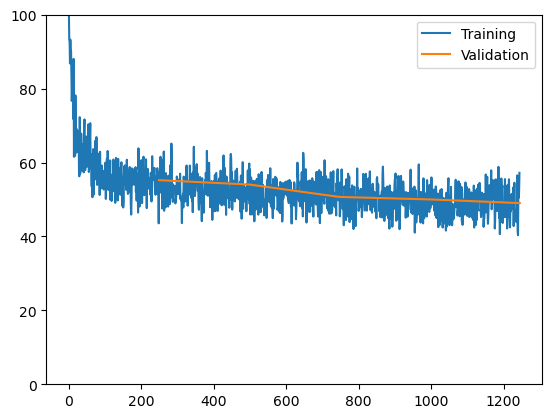

In [29]:
model = model_pipeline(transforms, CFG)